# Memory bandwidth of Grid'5000 nodes

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pytree
print(f'pytree {pytree.__version__}')
print(f'pytree {pytree.__git_version__}')

archive = 'bandwidth/1/grenoble_2020-09-22_1948870.zip'

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

df = read_csv(archive, 'result.csv')
df.head()

pytree 0.0.6
pytree daeffcbfbfb10dc9d69044bb110f965ab4e4e042


,function,size,timestamp,duration,hostname
0,memcpy,275446873,0.000000,0.054766,dahu-1.grenoble.grid5000.fr
1,memcpy,275446873,0.054788,0.054734,dahu-1.grenoble.grid5000.fr
2,memcpy,275446873,0.109525,0.054714,dahu-1.grenoble.grid5000.fr
3,memcpy,275446873,0.164241,0.054691,dahu-1.grenoble.grid5000.fr
4,memcpy,275446873,0.218935,0.054660,dahu-1.grenoble.grid5000.fr


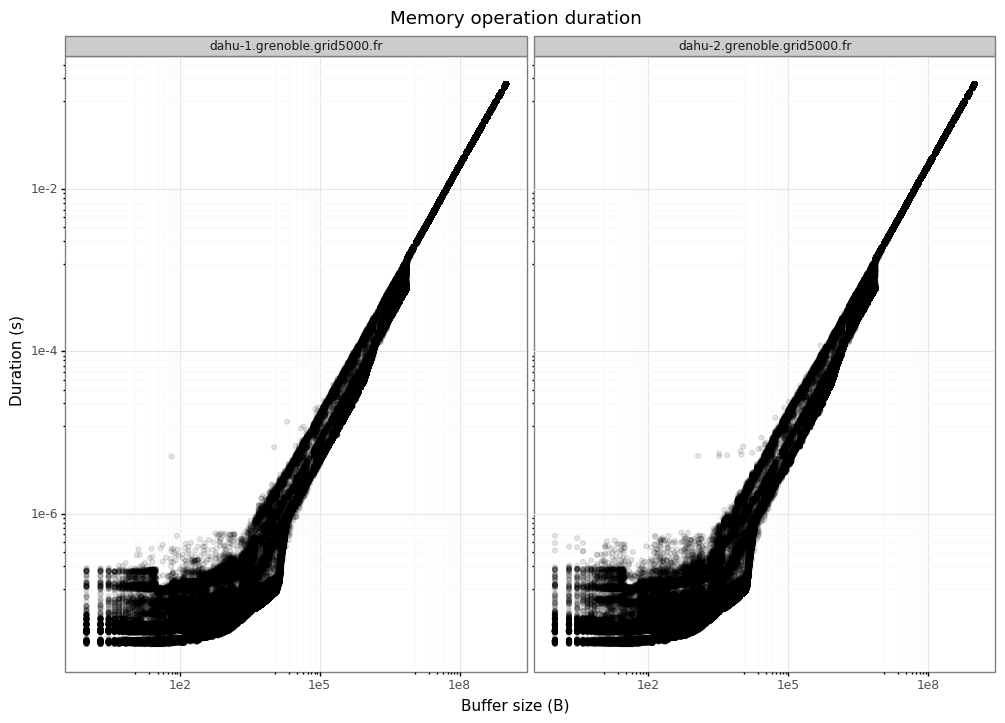

<ggplot: (-9223363302513988208)>

In [2]:
(ggplot(df)
    + aes(x='size', y='duration')
    + facet_wrap('hostname')
    + geom_point(alpha=0.1)
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
    + ggtitle('Memory operation duration')
    + labs(x='Buffer size (B)', y='Duration (s)')
)

In [3]:
caches = {
    'L1': 32768,
    'L2': 1048576,
    'L3': 23068672,
}

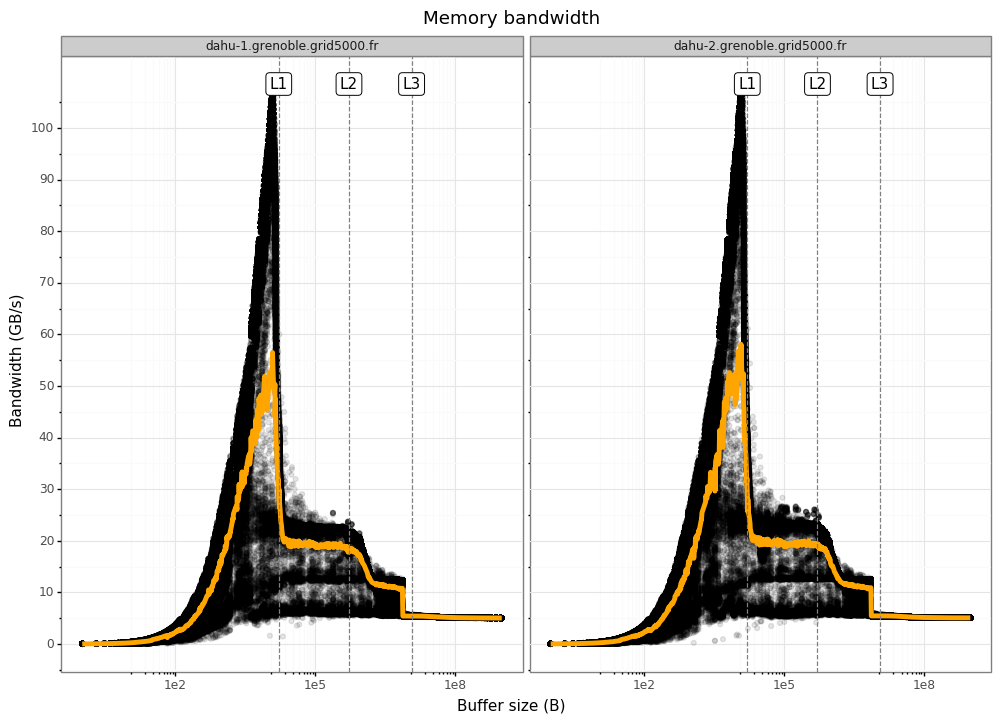

<ggplot: (8734332741587)>

In [4]:
df['bandwidth'] = df['size'] / df['duration'] * 1e-9
grouped = df.groupby(['hostname', 'size'])[['duration']].mean().reset_index()
grouped['bandwidth'] = grouped['size'] / grouped['duration'] * 1e-9

plot = (ggplot(df)
    + aes(x='size', y='bandwidth')
    + facet_wrap('hostname')
    + geom_point(alpha=0.1)
    + geom_line(data=grouped, color='orange', size=2)
    + scale_x_log10()
    + scale_y_continuous(breaks=range(0, 110, 10))
    + theme_bw()
    + ggtitle('Memory bandwidth')
    + labs(x='Buffer size (B)', y='Bandwidth (GB/s)')
)
for name, size in caches.items():
    plot += geom_vline(xintercept=size/2, linetype='dashed', color='gray')
    plot += annotate('label', label=name, x=size/2, y=df['bandwidth'].max())
plot

In [5]:
df[df['size'] > 1e8]['bandwidth'].median()

5.078577630421706

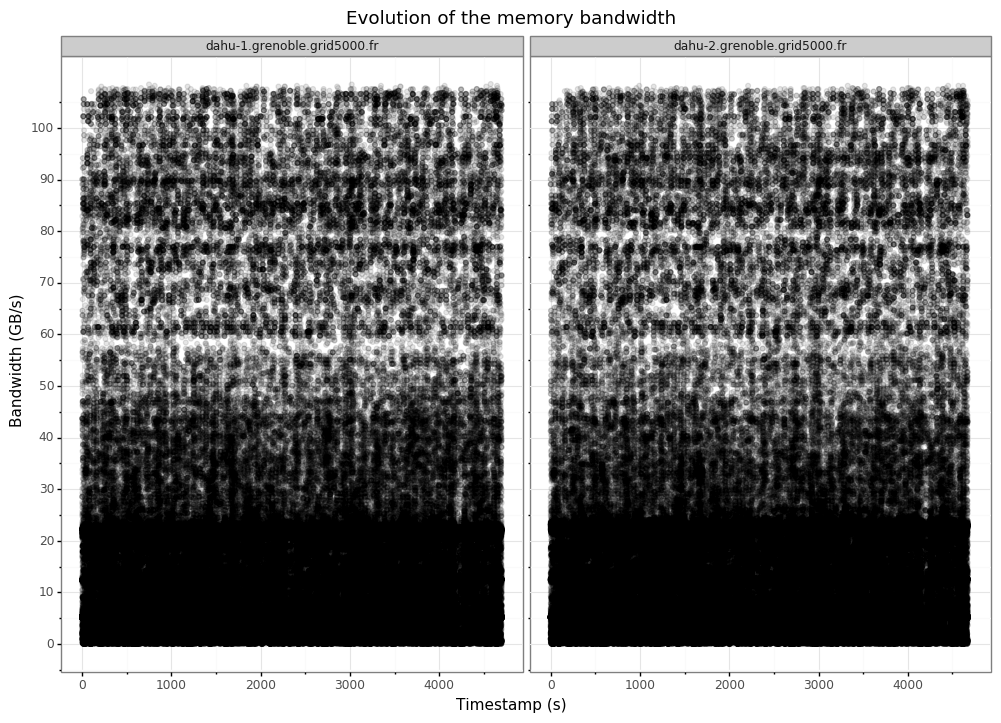

<ggplot: (8734332670633)>

In [6]:
(ggplot(df)
    + aes(x='timestamp', y='bandwidth')
    + facet_wrap('hostname')
    + geom_point(alpha=0.1)
    + scale_y_continuous(breaks=range(0, 110, 10))
    + theme_bw()
    + ggtitle('Evolution of the memory bandwidth')
    + labs(x='Timestamp (s)', y='Bandwidth (GB/s)')
)

## Trying a regression

[12640, 13581, 16000, 477185, 762446, 1106501, 7344568, 18077512, 27608546, 267807235, 612250514]
x ≤ 7.345e+06?
    └──x ≤ 1.107e+06?
    │    └──x ≤ 7.624e+05?
    │    │    └──x ≤ 4.772e+05?
    │    │    │    └──x ≤ 1.600e+04?
    │    │    │    │    └──x ≤ 1.264e+04?
    │    │    │    │    │    └──y ~ 1.547e-11x + 4.431e-08
    │    │    │    │    │    └──x ≤ 1.358e+04?
    │    │    │    │    │         └──y ~ -3.317e-12x + 3.148e-07
    │    │    │    │    │         └──y ~ 9.316e-11x + -9.813e-07
    │    │    │    │    └──y ~ 5.309e-11x + -9.811e-08
    │    │    │    └──y ~ 5.719e-11x + -1.080e-06
    │    │    └──y ~ 9.029e-11x + -2.786e-05
    │    └──y ~ 9.676e-11x + -2.497e-05
    └──x ≤ 2.761e+07?
         └──x ≤ 1.808e+07?
         │    └──y ~ 1.854e-10x + -9.013e-06
         │    └──y ~ 1.903e-10x + -9.998e-05
         └──x ≤ 6.123e+08?
              └──x ≤ 2.678e+08?
              │    └──y ~ 1.986e-10x + -3.274e-04
              │    └──y ~ 1.989e-10x + -3.974e-04
   

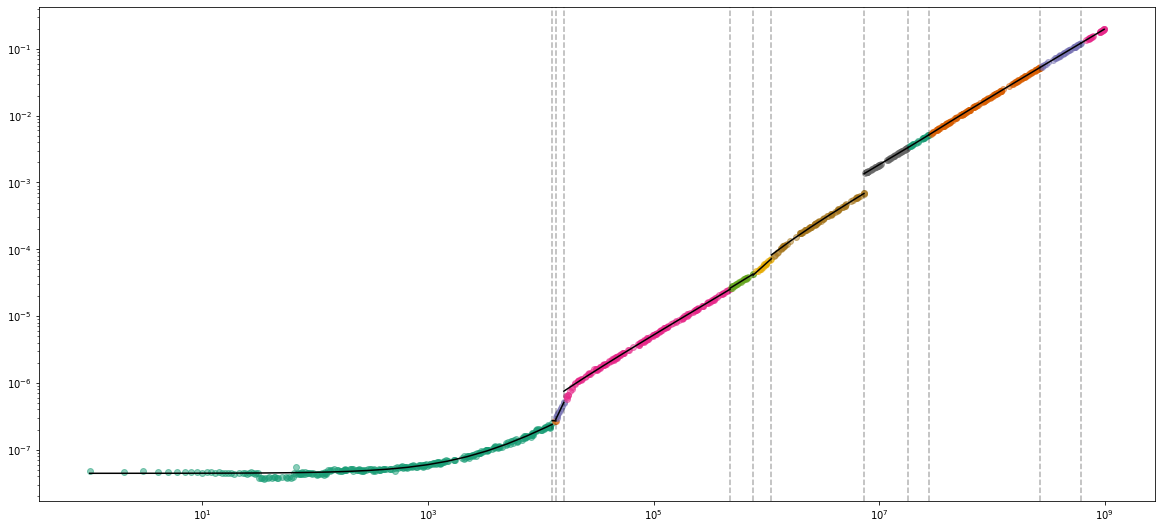

In [7]:
tmp = grouped[grouped['hostname'] == grouped['hostname'].min()]
reg = pytree.compute_regression(tmp['size'], tmp['duration'])
print(reg.breakpoints)
print(reg)
reg.plot_dataset(log=True)

[1106501, 7344568, 18077512, 27608546, 267807235, 612250514]
-inf < x ≤ 1.107e+06
	y ~ 5.845e-11x + -3.036e-07
1.107e+06 < x ≤ 7.345e+06
	y ~ 9.676e-11x + -2.497e-05
7.345e+06 < x ≤ 1.808e+07
	y ~ 1.854e-10x + -9.013e-06
1.808e+07 < x ≤ 2.761e+07
	y ~ 1.903e-10x + -9.998e-05
2.761e+07 < x ≤ 2.678e+08
	y ~ 1.986e-10x + -3.274e-04
2.678e+08 < x ≤ 6.123e+08
	y ~ 1.989e-10x + -3.974e-04
6.123e+08 < x ≤ inf
	y ~ 1.993e-10x + -7.268e-04


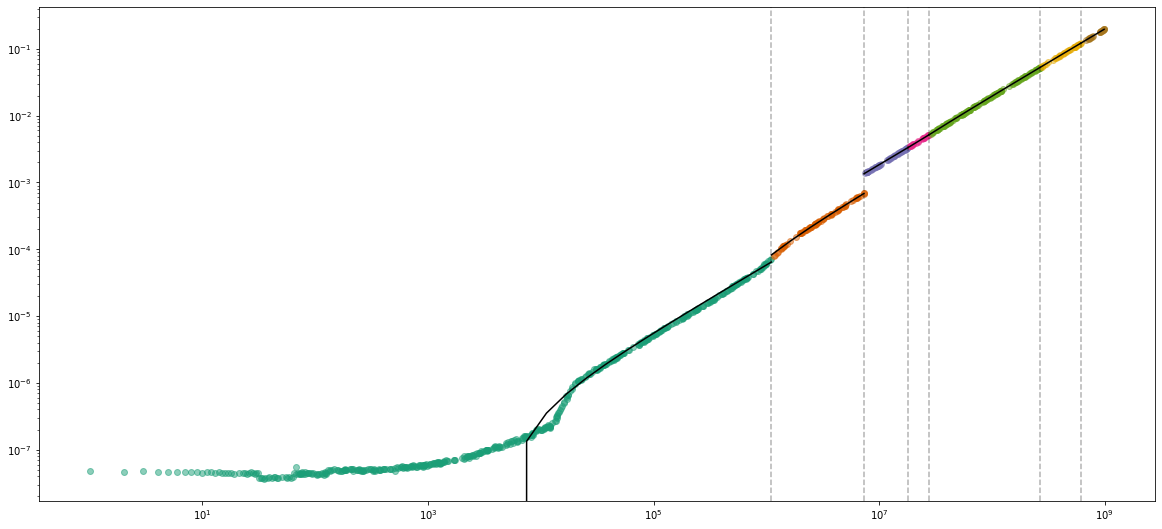

In [8]:
auto_simple = reg.auto_simplify()
print(auto_simple.breakpoints)
print(auto_simple)
auto_simple.plot_dataset(log=True)